In [2882]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/admm-lqr/Project.toml`


In [2883]:
using LinearAlgebra
using PyPlot

In [2884]:
#2D Double-integrator dynamics
h = 0.1 #20 Hz
A = [I(2) h*I(2); zeros(2,2) I(2)]
B = [0.5*h*h*I(2); h*I(2)];

In [2885]:
#Reference state trajectory to track (origin)
t = 0:h:10
N = length(t)
xref = zeros(4,N)
for k = 1:N
  xref[1:2,k] .= [(k/40);(-k/40)]
end
#Reference input trajectory
uref = zeros(2,N-1);

In [2886]:
#Cost Function
# J = Σ 0.5*(x-xref)'*Q*(x-xref) + 0.5*(u-uref)*R*(u-uref) + 0.5*xn'*Qn*xn
Qn = 10.0*I(4)
Q = 10.0*I(4)
R = 0.1*I(2)

q = zeros(4,N)
r = zeros(2,N-1)

function cost(x,u)
    J = 0.0
    for k = 1:(N-1)
        J += 0.5*(x[:,k]-xref[:,k])'*Q*(x[:,k]-xref[:,k]) + 0.5*(u[:,k]-uref[:,k])'*R*(u[:,k]-uref[:,k])
    end
    J += 0.5*(x[:,N]-xref[:,N])'*Qn*(x[:,N]-xref[:,N])
    return J
end

cost (generic function with 1 method)

In [2905]:
#ADMM Functions
function backward_pass!(A,B,Q,q,R,r,P,p,K,d)
    #This is the standard Riccati backward pass with both linear and quadratic terms (like iLQR)
    for k = (N-1):-1:1
        q[:,k] .= -Q*xref[:,k]
        K[:,:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
        d[:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*p[:,k+1] + r[:,k])
        r[:,k] .= -R*uref[:,k]
        P[:,:,k] .= Q + 1*K[:,:,k]'*R*K[:,:,k] + (A-1*B*K[:,:,k])'*P[:,:,k+1]*(A-B*K[:,:,k])
        p[:,k] .= q[:,k] + (A-B*K[:,:,k])'*(p[:,k+1]-P[:,:,k+1]*B*d[:,k]) + K[:,:,k]'*(R*d[:,k]-r[:,k])
    end
end

# function backward_pass_grad!(A,B,q,R,r,P,p,K,d)
#     #This is just the linear/gradient term from the backward pass (no cost-to-go Hessian or K calculations)
#     for k = (N-1):-1:1
#         d[:,k] .= Quu_inv*(B'*p[:,k+1] + r[:,k])
#         p[:,k] .= q[:,k] + AmBKt*(p[:,k+1]-Pinf*B*d[:,k]) + Kinf'*(R*d[:,k]-r[:,k])
#     end
# end

function backward_pass_grad!(A,B,q,R,r,P,p,K,m)
    #This is just the linear/gradient term from the backward pass (no cost-to-go Hessian or K calculations)
    for k = (N-1):-1:1
        d[:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*p[:,k+1] + r[:,k])
        p[:,k] .= q[:,k] + (A-B*K[:,:,k])'*(p[:,k+1]-P[:,:,k+1]*B*d[:,k]) + K[:,:,k]'*(R*d[:,k]-r[:,k])
    end
end

function forward_pass!(A,B,K,d,x,u)
    for k = 1:(N-1)
        u[:,k] .= -K[:,:,k]*(x[:,k]-0*xref[:,k]) - 1*d[:,k] + uref[:,k]
        x[:,k+1] .= A*(x[:,k]+0*xref[:,k]) + B*(u[:,k]+0*uref[:,k]) - 0*xref[:,k+1]
    end
end

function update_primal!(A,B,q,R̃,r,P,p,K,d,x,u)
    backward_pass_grad!(A,B,q,R̃,r,P,p,K,d)
    forward_pass!(A,B,K,d,x,u)
end
function update_slack!(u,z,y)
    #This function clamps the controls to be within the bounds
    for k = 1:(N-1)
        z[:,k] .= min.(umax, max.(umin, u[:,k]+y[:,k]))
    end
end

function update_dual!(u,z,y)
    #This function performs the standard AL multiplier update.
    #Note that we're using the "scaled form" where y = λ/ρ
    for k = 1:(N-1)
        y[:,k] .= y[:,k] + u[:,k] - z[:,k]
    end
end

function update_linear_cost!(z,y,r)
    #This function updates the linear term in the control cost to handle the changing cost term from ADMM
    for k = 1:(N-1)
        r[:,k] .= -ρ*(z[:,k]-y[:,k])
    end
end

update_linear_cost! (generic function with 2 methods)

In [2888]:
#Control Bounds
umin = -[1.0; 1.0]*1
umax = [1.0; 1.0]*1;

In [2906]:
#Algorithm Setup

x = zeros(4,N)
x[:,1] .= [1.0; 0; 0; 1.0]
u = zeros(2,N-1)

ρ = 1e0
R̃ = R + 1*ρ*I

P = zeros(4,4,N)
P[:,:,N] .= Qn
p = zeros(4,N)
p[:,N] .= -P[:,:,N]*xref[:,N]  #q[:,N]

K = zeros(2,4,N-1)
d = zeros(2,N-1)

z = zeros(2,N-1);
znew = zeros(2,N-1);
y = zeros(2,N-1);

backward_pass!(A,B,Q,q,R̃,r,P,p,K,d)
Pinf = 1*P[:,:,1]
Kinf = 1*K[:,:,1]
Quu_inv = (R̃ + B'*Pinf*B)\I
AmBKt = (A-B*Kinf)'

4×4 adjoint(::Matrix{Float64}) with eltype Float64:
 0.98758    0.0        -0.248393   0.0
 0.0        0.98758     0.0       -0.248393
 0.0833134  0.0         0.666268   0.0
 0.0        0.0833134   0.0        0.666268

In [2890]:
#Main algorithm loop

# I count this as one iteration by including it into the for loop
forward_pass!(A,B,K,d,x,u)
update_slack!(u,z,y)
update_dual!(u,z,y)
update_linear_cost!(z,y,r)

iter = 0
primal_residual = 1.0
dual_residual = 1.0
for k = 1:500
    update_primal!(A,B,q,R̃,r,P,p,K,d,x,u)
    update_slack!(u,znew,y)
    update_dual!(u,znew,y)
    update_linear_cost!(znew,y,r)
    
    primal_residual = maximum(abs.(u-z))
    dual_residual = maximum(abs.(ρ*(znew-z)))
    if (primal_residual < 0.01 && dual_residual < 0.01)
        break
    end

    z .= znew
    iter += 1
end

In [2891]:
iter

500

In [2892]:
# Kinf = zeros(nu, nx)
# P = 1*Q
# for ricatti_iter = 1:100
#     Kinf = (R + B' * P * B) \ (B' * P * A)
#     P = Q + A' * P * (A - B * Kinf)
# end    
# # TODO: simulate this controlled system with rk4(params_real, ...)
# for k = 1:(N-1)
#     u[:,k] .= -0.01*Kinf*(x[:,k]-1*xref[:,k]) 
#     x[:,k+1] .= A*x[:,k] + B*u[:,k]
# end

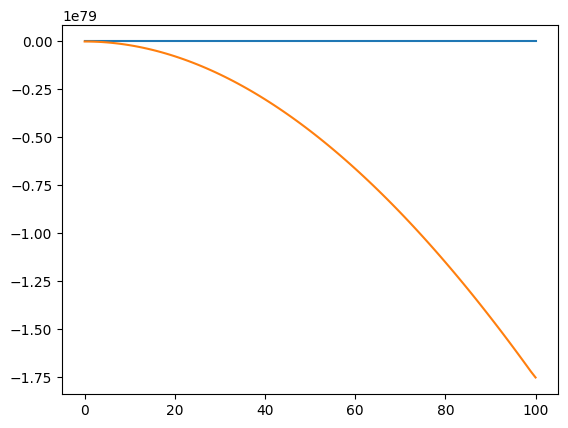

In [2893]:
fig = plt.figure()
plot(xref[1,:])
plot(x[1,:]+0*xref[1,:])
fig

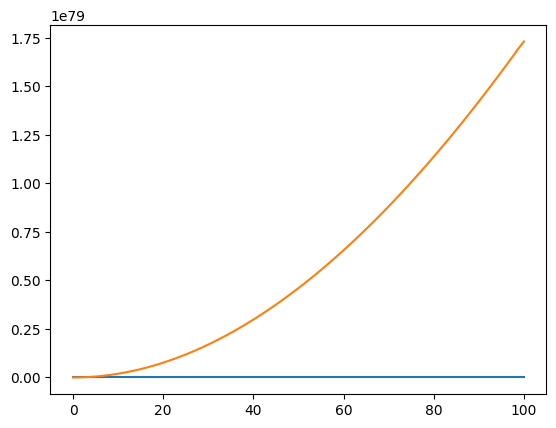

In [2894]:
fig = plt.figure()
plot(xref[2,:])
plot(x[2,:]+0*xref[2,:])
fig

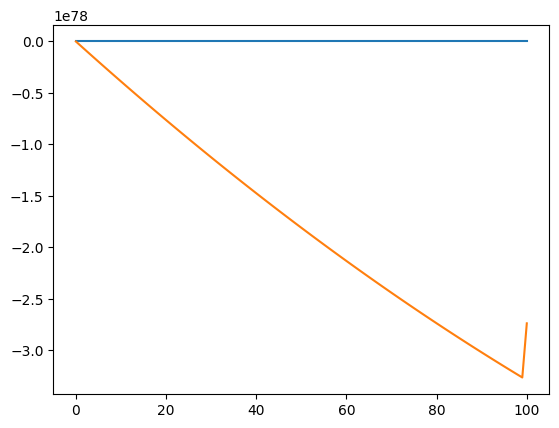

In [2895]:
fig = plt.figure()
plot(xref[3,:])
plot(x[3,:]+0*xref[3,:])
fig

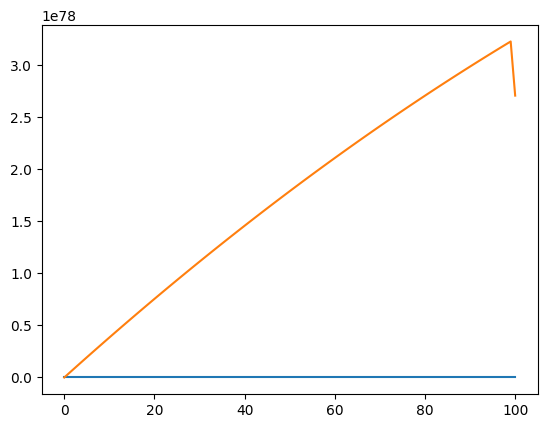

In [2896]:
fig = plt.figure()
plot(xref[4,:])
plot(x[4,:]+0*xref[4,:])
fig

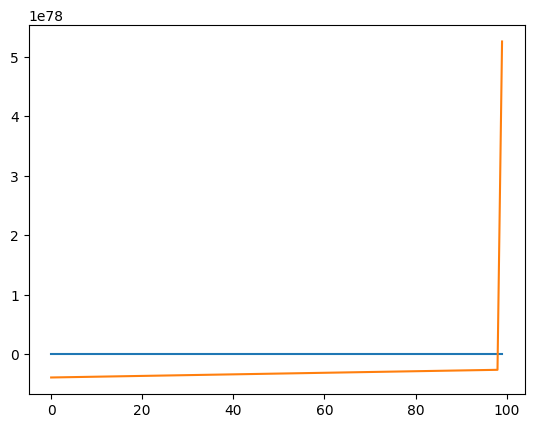

In [2897]:
fig = plt.figure()
plot(uref[1,:])
plot(u[1,:])
fig

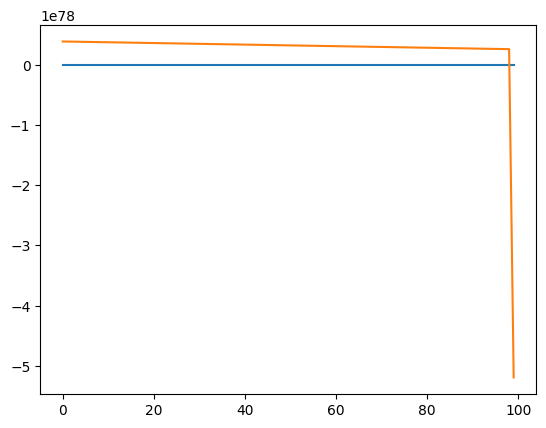

In [2898]:
fig = plt.figure()
plot(uref[2,:])
plot(u[2,:])
fig

In [2899]:
plot(y[1,:])
plot(y[2,:])

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7a0b4190d0>

In [2900]:
plot(z[1,:])
plot(z[2,:])

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7a0b3c0f10>